## Import

In [8]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
import random

#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#import Deep learning tools
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from keras.optimizers import Adam , Adamax
from keras.utils import to_categorical
from keras import regularizers

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [68]:
def plot_history(history):

    epochs_range = range(1, len(history.history['loss'])+1)

    # plot accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # plot loss curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Define Constants

In [9]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE = 64

## Dataset Organization

### Unzip Data

In [10]:
!unzip /content/drive/MyDrive/test1.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg     

In [11]:
!unzip /content/drive/MyDrive/train.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg 

In [14]:
img_list = os.listdir('/content/train')
len(imwg_list)

25000

### Prepare Main Dataframe

In [15]:
categories = []
for filename in img_list:
    if filename.startswith('dog'):
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': img_list,
    'category': categories
})

In [16]:
df.head(10)

filename category
0   cat.6560.jpg      cat
1   dog.5958.jpg      dog
2   cat.8959.jpg      cat
3   dog.3787.jpg      dog
4   cat.6015.jpg      cat
5   dog.1937.jpg      dog
6   dog.3579.jpg      dog
7   dog.7129.jpg      dog
8  dog.10578.jpg      dog
9  cat.11384.jpg      cat

<Axes: >

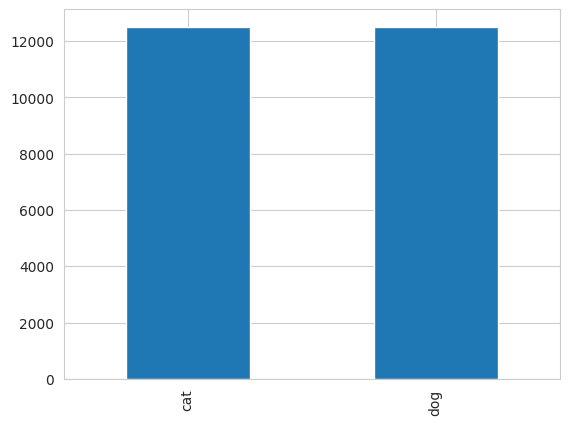

In [17]:
df['category'].value_counts().plot.bar()

#### See Sample image

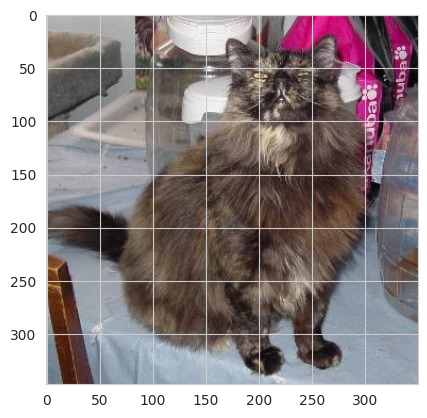

In [18]:
sample = random.choice(img_list)
image = load_img("/content/train/"+sample)
plt.imshow(image)

### Prepare Data for Training and Validating

In [19]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
# train_df = train_df.reset_index(drop=True)
# validate_df = validate_df.reset_index(drop=True)

In [20]:
train_number = train_df.shape[0]
validate_number = validate_df.shape[0]
train_number, validate_number

(20000, 5000)

## Data Generator

### Training Generator

In [21]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


### Validate Generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


**See how generator work**

In [23]:
example_df = train_df.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


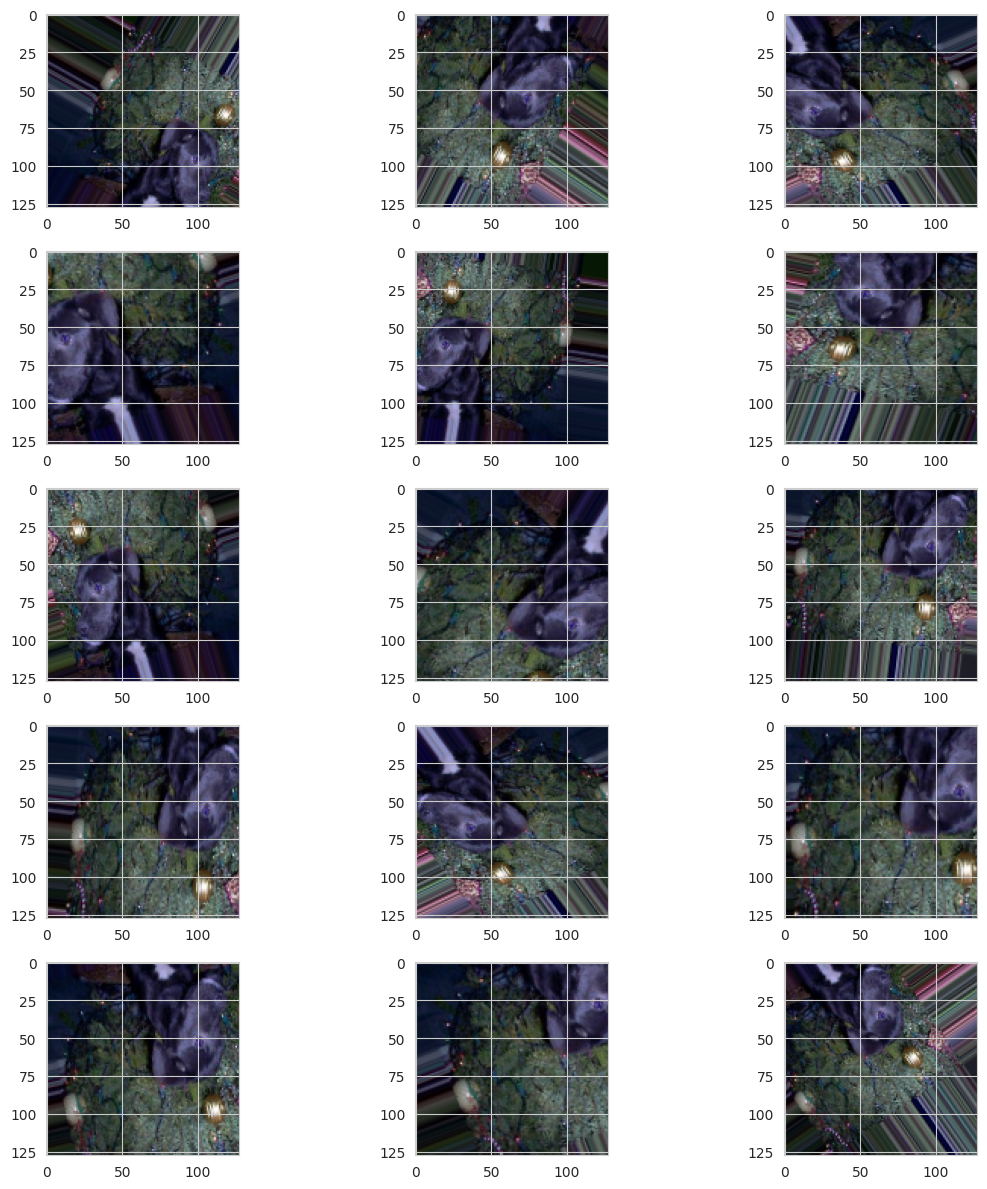

In [24]:
plt.figure(figsize=(12,12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Callbacks

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [26]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

**Define callbacks list**

In [33]:
callbacks = [earlystop, learning_rate_reduction]


## Build Model

* Input Layer: It represent input image data. It will reshape image into single diminsion array. Example the image is 64x64 = 4096, it will convert to (4096,1) array.
* Conv Layer: This layer will extract features from image.
* Pooling Layer: This layer reduce the spatial volume of input image after convolution.
* Fully Connected Layer: It connect the network from a layer to another layer
* Output Layer: It is the predicted values layer.

In [29]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

## Fit Model

In [34]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validate_number//BATCH_SIZE,
    steps_per_epoch=train_number//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50
312/312 [==============================] - 140s 446ms/step - loss: 0.5617 - accuracy: 0.7123 - val_loss: 2.3596 - val_accuracy: 0.5627 - lr: 0.0010
Epoch 2/50
312/312 [==============================] - 140s 448ms/step - loss: 0.5433 - accuracy: 0.7266 - val_loss: 0.5066 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 3/50
312/312 [==============================] - 136s 435ms/step - loss: 0.5261 - accuracy: 0.7375 - val_loss: 0.9336 - val_accuracy: 0.5966 - lr: 0.0010
Epoch 4/50
312/312 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7551
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
312/312 [==============================] - 139s 446ms/step - loss: 0.5022 - accuracy: 0.7551 - val_loss: 0.6423 - val_accuracy: 0.6953 - lr: 0.0010
Epoch 5/50
312/312 [==============================] - 136s 437ms/step - loss: 0.4695 - accuracy: 0.7736 - val_loss: 0.4852 - val_accuracy: 0.7915 - lr: 5.0000e-04
Epoch 6/50
312/312 [====================

### Evaluate Model

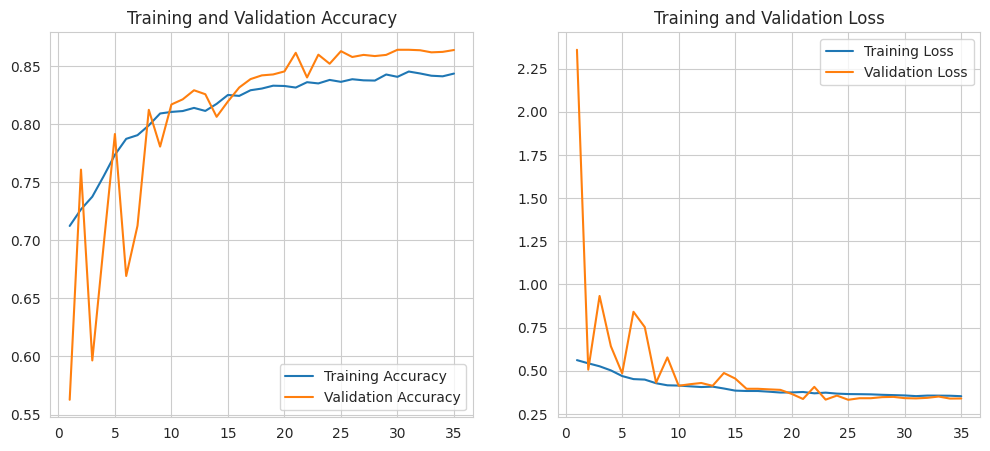

In [69]:
plot_history(history)

In [70]:
print("Training Accuracy: ", model.evaluate(train_generator, verbose=None)[1])
print("Validation Accuracy: ", model.evaluate(validation_generator, verbose=None)[1])

Training Accuracy:  0.8575999736785889
Validation Accuracy:  0.8640000224113464


### Save Model

In [36]:
model.save_weights("/content/drive/MyDrive/Dog_and_Cat/model/model.h5")
model.save("/content/drive/MyDrive/Dog_and_Cat/model/my_model.keras")

## Prepare Testing Data

### Load test Data

In [61]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df

filename
0       7960.jpg
1       6008.jpg
2       6067.jpg
3       1759.jpg
4      10356.jpg
...          ...
12495   8872.jpg
12496  11633.jpg
12497   9494.jpg
12498   5710.jpg
12499    948.jpg

[12500 rows x 1 columns]

### Create Testing Generator

In [44]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    "/content/test1",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [45]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

196/196 [==============================] - 22s 113ms/step


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max



In [49]:
np.argmax(predict, axis=-1)

array([1, 0, 1, ..., 0, 0, 0])

In [76]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [77]:
test_df.head(10)

filename  category
0   7960.jpg         1
1   6008.jpg         0
2   6067.jpg         1
3   1759.jpg         1
4  10356.jpg         0
5   2380.jpg         0
6   5582.jpg         0
7  11457.jpg         0
8  11879.jpg         1
9  11024.jpg         1

### Visualize Result

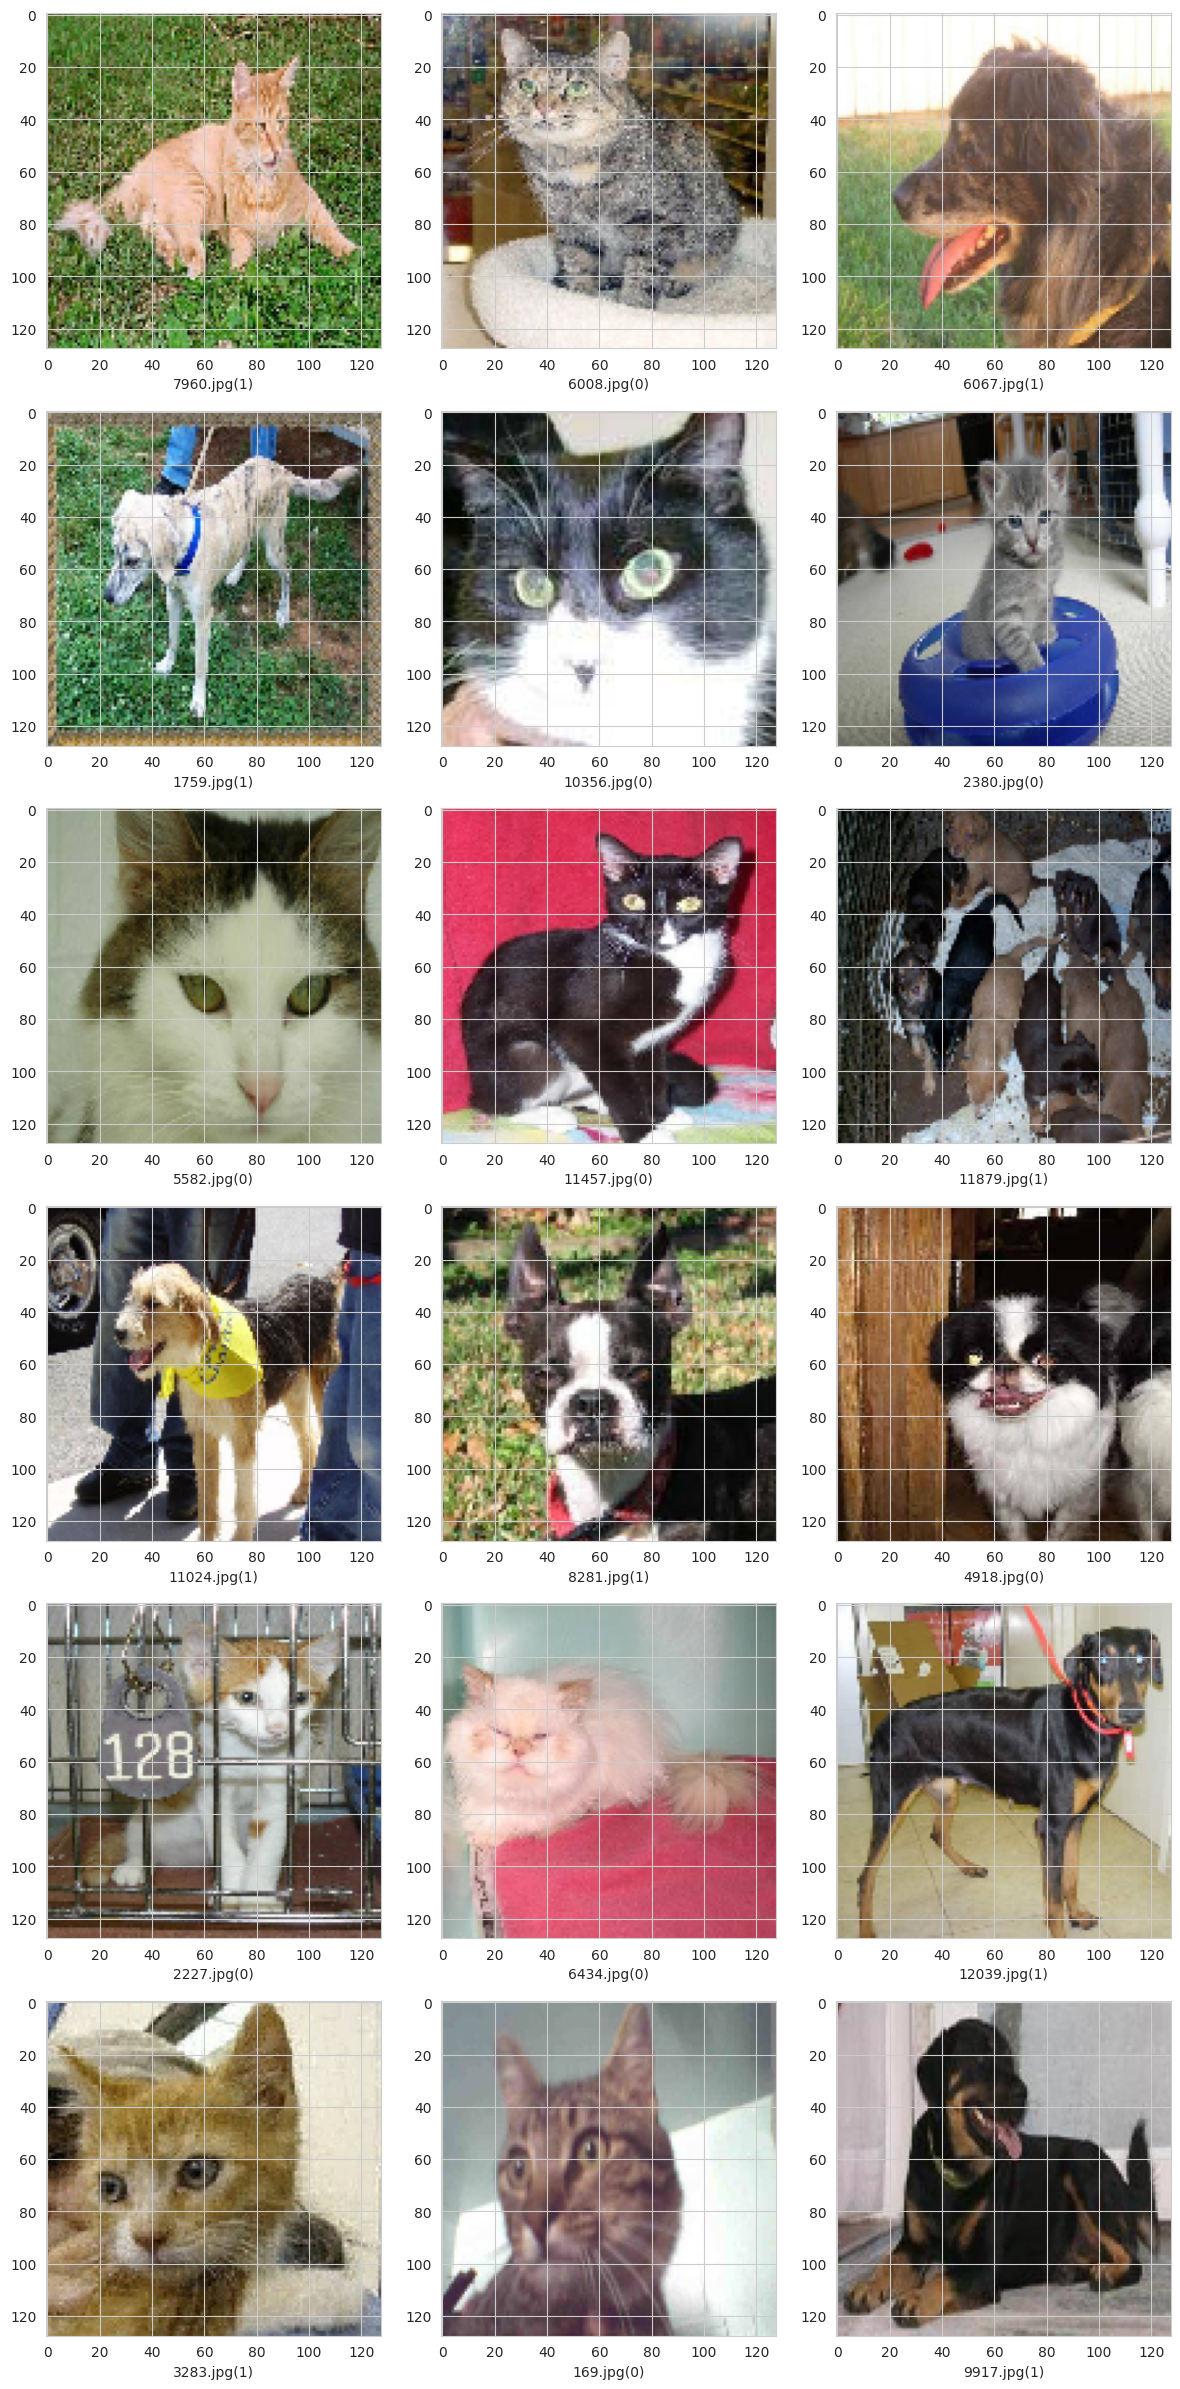

In [78]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
